# Import Dependencies

In [1]:
import os
import datetime 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
import cv2 
import glob 
import threading 

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Activation, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.models import Model

# added these imports found on this page https://github.com/tensorflow/tensorflow/issues/33474 to load model and save
# this is the best way to load a model 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
from collections import Counter 
from concurrent import futures 

# Import Data and Load into DataFrames 

In [7]:
# define base directory where images are found 
base_dir = os.path.join('./cell_images')

In [8]:
# parasitized files 
para_dir = os.path.join(base_dir,'Parasitized')
para_files = glob.glob(para_dir+'/*.png')
len(para_files)

13779

In [9]:
# healthy files 
healthy_dir = os.path.join(base_dir,'Uninfected')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(healthy_files)

13779

In [10]:
df = pd.DataFrame({'filename': para_files + healthy_files,
           'label': ['Parasitized'] * len(para_files) + 
                    ['Uninfected'] * len(healthy_files)}).sample(frac=1, random_state=42).reset_index(drop=True)

df.head()
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27558 entries, 0 to 27557
Data columns (total 2 columns):
filename    27558 non-null object
label       27558 non-null object
dtypes: object(2)
memory usage: 430.7+ KB


(27558, 2)

# Setting up Training, Testing, Validation Sets (train-test split)


We're using a 63% training, 7% validation, and 30% testing split and each set has a roughly 50:50 split between infected and uninfected

In [151]:
# train test split and get shape of files 
train_files, test_files, train_labels, test_labels = train_test_split(df['filename'].values,
                                                                      df['label'].values,
                                                                      test_size=0.3, random_state=42)

train_files, valid_files, train_labels, valid_labels = train_test_split(train_files,
                                                                    train_labels,
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, valid_files.shape, test_files.shape)
print('Training:', Counter(train_labels),'\nValidation:', Counter(valid_labels), '\nTesting:', Counter(test_labels))

(17361,) (1929,) (8268,)
Training: Counter({'Uninfected': 8734, 'Parasitized': 8627}) 
Validation: Counter({'Uninfected': 970, 'Parasitized': 959}) 
Testing: Counter({'Parasitized': 4193, 'Uninfected': 4075})


# Image Pre-Processing (this takes forever) 

In [152]:
def get_img_shape_parallel(index, image, total_images):
    if index % 5000 == 0 or index == (total_images - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name, index))
        
    return cv2.imread(image).shape
  
execute = futures.ThreadPoolExecutor(max_workers=None)
data_input = [(index, image, len(train_files)) for index, image in enumerate(train_files)]
print('Starting Image shape Computations...')

train_image_dimensions_map = execute.map(get_img_shape_parallel, 
                            [record[0] for record in data_input],
                            [record[1] for record in data_input],
                            [record[2] for record in data_input])
train_image_dimensions = list(train_image_dimensions_map)

print('Min Dimensions:', np.min(train_image_dimensions, axis=0)) 
print('Avg Dimensions:', np.mean(train_image_dimensions, axis=0))
print('Median Dimensions:', np.median(train_image_dimensions, axis=0))
print('Max Dimensions:', np.max(train_image_dimensions, axis=0))

Starting Image shape Computations...
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_31: working on img num: 5000
ThreadPoolExecutor-2_19: working on img num: 10000
ThreadPoolExecutor-2_24: working on img num: 15000
ThreadPoolExecutor-2_35: working on img num: 17360
Min Dimensions: [46 46  3]
Avg Dimensions: [132.9369276  132.32279247   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [385 364   3]


Threading
- Return the current Thread object, corresponding to the caller’s thread of control.
- asynchronous execution can be performed with threads

When you create a Thread, you pass it a function and a list containing the arguments to that function. In this case, you’re telling the Thread to run thread_function() and to pass it 1 as an argument.

# Parallel Processing (this takes forever and a day)

Parallel computing completes multiple processes at once. If you were to receive large amounts of fresh data points in a specified unit of time, you might need this type of processing to clean, condense and feed them into a machine-learning model simultaneously.
Source: https://builtin.com/big-data/parallel-processing-climacell-weather?utm_medium=email&utm_source=transactional&utm_campaign=Content-Newsletter

In [153]:
image_dimensions = img_dims = (130, 130)

def get_img_data_parallel(index, image, total_images):
    if index % 5000 == 0 or index == (total_images - 1):
        print('{}: working on image number: {}'.format(threading.current_thread().name, index))
    image = cv2.imread(image)
    image = cv2.resize(image, dsize= img_dims, 
                     interpolation=cv2.INTER_CUBIC)
    image = np.array(image, dtype=np.float32)
    return image

execute = futures.ThreadPoolExecutor(max_workers=None)

train_data_input = [(index, image, len(train_files)) for index, image in enumerate(train_files)]
valid_data_input = [(index, image, len(valid_files)) for index, image in enumerate(valid_files)]
test_data_input = [(index, image, len(test_files)) for index, image in enumerate(test_files)]

print('Loading Train Images...')
train_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in train_data_input],
                        [record[1] for record in train_data_input],
                        [record[2] for record in train_data_input])
train_data = np.array(list(train_data_map))
print(f"Training Data Shape: {train_data.shape}")
print("-"*60)
print('Loading Validation Images...')
valid_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in valid_data_input],
                        [record[1] for record in valid_data_input],
                        [record[2] for record in valid_data_input])
valid_data = np.array(list(valid_data_map))
print(f"Validation Data Shape: {valid_data.shape}")
print("-"*60)
print('Loading Test Images...')
test_data_map = execute.map(get_img_data_parallel, 
                        [record[0] for record in test_data_input],
                        [record[1] for record in test_data_input],
                        [record[2] for record in test_data_input])
test_data = np.array(list(test_data_map))
print(f"Testing Data Shape: {test_data.shape}")

Loading Train Images...
ThreadPoolExecutor-3_0: working on image number: 0
ThreadPoolExecutor-3_17: working on image number: 5000
ThreadPoolExecutor-3_39: working on image number: 10000
ThreadPoolExecutor-3_15: working on image number: 15000
ThreadPoolExecutor-3_18: working on image number: 17360
Training Data Shape: (17361, 130, 130, 3)
------------------------------------------------------------
Loading Validation Images...
ThreadPoolExecutor-3_11: working on image number: 0
ThreadPoolExecutor-3_17: working on image number: 1928
Validation Data Shape: (1929, 130, 130, 3)
------------------------------------------------------------
Loading Test Images...
ThreadPoolExecutor-3_31: working on image number: 0
ThreadPoolExecutor-3_20: working on image number: 5000
ThreadPoolExecutor-3_22: working on image number: 8267
Testing Data Shape: (8268, 130, 130, 3)


In [154]:
# configure data with labels and scaling
scaled_train_images = train_data / 255
scaled_valid_images = valid_data / 255

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
enc_train_labels = le.transform(train_labels)
enc_valid_labels = le.transform(valid_labels)

Now all our images are the same shape, which helps normalize the data

['Parasitized' 'Parasitized' 'Parasitized' 'Uninfected' 'Uninfected'
 'Parasitized' 'Uninfected' 'Parasitized' 'Uninfected' 'Uninfected'
 'Uninfected' 'Uninfected' 'Uninfected' 'Parasitized' 'Parasitized'
 'Parasitized'] [0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0]


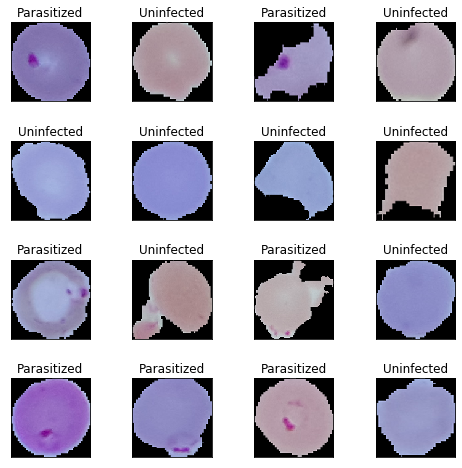

In [15]:
# use matplotlib to print pictures 
plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])
    
print(train_labels[:16], enc_train_labels[:16])

# Now for the Neural Network (From Scratch)

In [16]:
# define image input shape and define inputs
input_shape = (130, 130, 3)
input = tf.keras.layers.Input(shape= input_shape)

In [17]:
# build model architecture 
conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(input)
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool_1)
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(pool_2)
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_3)

flat = tf.keras.layers.Flatten()(pool_3)

In [18]:
# build-in dropouts since this dataset is relatively small, over-fitting is likely. The drop out rate of 0.5 is chosen arbitrarily. 
hidden_1 = tf.keras.layers.Dense(512, activation='relu')(flat)
dropout_1 = tf.keras.layers.Dropout(rate=0.5)(hidden_1)

hidden_2 = tf.keras.layers.Dense(512, activation='relu')(dropout_1)
dropout_2 = tf.keras.layers.Dropout(rate=0.5)(hidden_2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_2)

INPUT holds raw pixel values of the image

CONV layers compute the output connected to local regions in the input, each computing a dot product between their weights and a small region they are connected to in the input volume

RELU layer applies an elementwise activation function, thresholding at zero. This leaves the size of the volume unchanged.
 
POOL layer performs a downsampling operation along the spatial dimensions (width, height)
http://cs231n.github.io/convolutional-networks/

HIDDEN layer contains values are not observed in the training set.
https://towardsdatascience.com/understanding-neural-networks-from-neuron-to-rnn-cnn-and-deep-learning-cd88e90e0a90

DROPOUT refers not considering certain units during a particular forward or backward pass. units during the training phase of certain set of units which is chosen at random; individual nodes are either dropped out of the net with probability 1-p or kept with probability p during each training pass so that a reduced network is left; incoming and outgoing edges to a dropped-out node are also removed.
https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

In [19]:
my_model = tf.keras.Model(inputs = input, outputs = output)

In [20]:
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 130, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 130, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0     

In [21]:
# import datetime
logdir = os.path.join('../tensorboard_logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [22]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]

# ReduceLROnPlateau = Reduce learning rate when a metric has stopped improving.
# callback is a set of functions to be applied at given stages of the training procedure
# https://keras.io/callbacks/

In [ ]:
# # this feature will save weights only during training, 
# # such that you can pick up training where you left it if you needed to stop during training
# checkpoint_path = "tensor_board_logs/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
# base_out = base_vgg.output
# my_model.fit(train_images, 
#           train_labels,  
#           epochs=10,
#           validation_data=(test_images,test_labels),
#           callbacks=[cp_callback])  # Pass callback to training

# # This may generate warnings related to saving the state of the optimizer.
# # These warnings (and similar warnings throughout this notebook)
# # are in place to discourage outdated usage, and can be ignored.

# # https://www.tensorflow.org/tutorials/keras/save_and_load

In [23]:
# Definitions for later 
Batch_Size = 64
# Number of samples per gradient update
number_classes = 2 
# total number of classes
Epics = 25
# "EPOCHS" spelled wrong; an arbitrary cutoff, generally defined as “one pass over the entire dataset”, 
# used to separate training into distinct phases
Validation = (scaled_valid_images, enc_valid_labels)

In [24]:
history = my_model.fit(x=scaled_train_images, 
                    y=enc_train_labels, 
                    batch_size=Batch_Size, 
                    epochs=Epics, 
                    validation_data=Validation,
                    callbacks=callbacks, 
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 184s 11ms/sample - loss: 0.5026 - accuracy: 0.7520 - val_loss: 0.1860 - val_accuracy: 0.9435
Epoch 2/25
17361/17361 [==============================] - 176s 10ms/sample - loss: 0.1655 - accuracy: 0.9479 - val_loss: 0.1487 - val_accuracy: 0.9523
Epoch 3/25
17361/17361 [==============================] - 169s 10ms/sample - loss: 0.1371 - accuracy: 0.9574 - val_loss: 0.1402 - val_accuracy: 0.9539
Epoch 4/25
17361/17361 [==============================] - 169s 10ms/sample - loss: 0.1247 - accuracy: 0.9598 - val_loss: 0.1363 - val_accuracy: 0.9575
Epoch 5/25
17361/17361 [==============================] - 168s 10ms/sample - loss: 0.1116 - accuracy: 0.9631 - val_loss: 0.1408 - val_accuracy: 0.9580
Epoch 6/25
17361/17361 [==============================] - 169s 10ms/sample - loss: 0.0969 - accuracy: 0.9673 - val_loss: 0.1458 - val_accuracy: 0.9575
Epoch 7/25
17361/17361 [=====================

In [25]:
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

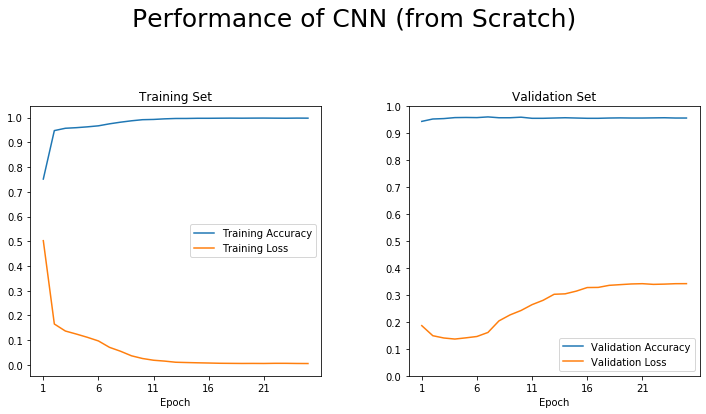

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
t = f.suptitle('Performance of CNN (from Scratch)', fontsize=25)
f.subplots_adjust(top=0.75, wspace=0.3)

# figure 1
ax1.plot(epoch_list, history.history['accuracy'], label='Training Accuracy')
ax1.plot(epoch_list, history.history['loss'], label='Training Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0, 1.1, step=0.1))
ax1.set_xlabel('Epoch')
ax1.set_title('Training Set')

l1 = ax1.legend(loc="best")

# figure 2
ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0, 1.1, step=0.1))
ax2.set_xlabel('Epoch')
ax2.set_title('Validation Set')

l2 = ax2.legend(loc="best")

In [27]:
type(my_model)
my_model.save("my_cnn.h5")

In [28]:
test = tf.keras.models.load_model('my_cnn.h5')
test.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 130, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 130, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0     

# And Another One *DJ Khalid Voice* (Just kidding, it's just VGG19
## She's back and better than ever

In [71]:
Input_Shape = (130, 130, 3)

In [72]:
# Freeze the layers
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=Input_Shape)
vgg.trainable = False

for layer in vgg.layers:
    layer.trainable = False

In [73]:
for layer in vgg.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x147857d90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147857c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x1156486d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x1478716d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147873f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147fac050> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x147fac890> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147886f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147325ed0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147346410> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x147336e10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x147351590> False
<tensorflow.py

In [74]:
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)

In [75]:
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)

hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

In [76]:
ft_model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
ft_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
ft_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 130, 130, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 130, 130, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 130, 130, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 65, 65, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 65, 65, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 65, 65, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [78]:
print("Total Layers:", len(ft_model.layers))
print("Total trainable layers:", sum([1 for l in ft_model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


fine-tuning a network is to tweak the parameters of an already trained network so that it adapts to the new task

initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact ( or freeze them ) and retrain the later layers for our task.

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

In [80]:
# Definitions for later 
Batch_Size = 64
# Number of samples per gradient update
number_classes = 2 
# total number of classes
Epics = 25
# "EPOCHS" spelled wrong; an arbitrary cutoff, generally defined as “one pass over the entire dataset”, 
# used to separate training into distinct phases
Validation = (scaled_valid_images, enc_valid_labels)

In [82]:
history = ft_model.fit(x=scaled_train_images, 
                    y=enc_train_labels, 
                    batch_size=Batch_Size, 
                    epochs=Epics, 
                    validation_data=Validation,
                    callbacks=callbacks, 
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 910s 52ms/sample - loss: 0.1521 - accuracy: 0.9452 - val_loss: 0.1763 - val_accuracy: 0.9393
Epoch 2/25
17361/17361 [==============================] - 955s 55ms/sample - loss: 0.1489 - accuracy: 0.9448 - val_loss: 0.2051 - val_accuracy: 0.9238
Epoch 3/25
17361/17361 [==============================] - 938s 54ms/sample - loss: 0.1443 - accuracy: 0.9476 - val_loss: 0.1880 - val_accuracy: 0.9342
Epoch 4/25
17361/17361 [==============================] - 937s 54ms/sample - loss: 0.1299 - accuracy: 0.9537 - val_loss: 0.1835 - val_accuracy: 0.9388
Epoch 5/25
17361/17361 [==============================] - 960s 55ms/sample - loss: 0.1260 - accuracy: 0.9546 - val_loss: 0.1884 - val_accuracy: 0.9362
Epoch 6/25
17361/17361 [==============================] - 968s 56ms/sample - loss: 0.1197 - accuracy: 0.9576 - val_loss: 0.1771 - val_accuracy: 0.9409
Epoch 7/25
17361/17361 [=====================

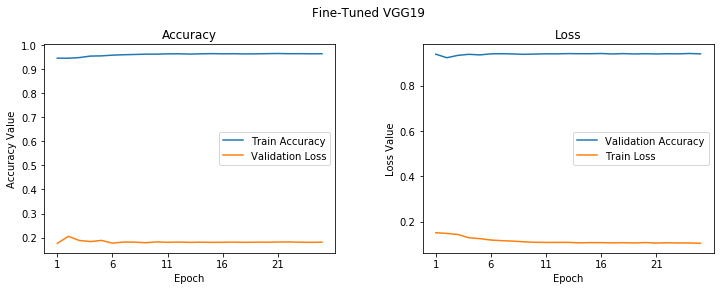

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Fine-Tuned VGG19', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_loss'], label='Validation Loss')

ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')

ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [84]:
# Definitions for later 
Batch_Size = 64
# Number of samples per gradient update
number_classes = 2 
# total number of classes
Epics = 25
# "EPOCHS" spelled wrong; an arbitrary cutoff, generally defined as “one pass over the entire dataset”, 
# used to separate training into distinct phases
Validation = (scaled_valid_images, enc_valid_labels)

In [87]:
type(ft_model)
ft_model.save("my_ft_vgg.h5")

# Making Comparisons and Drawing Conclusions 

In [167]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

In [168]:
# load and scale testing images
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 130, 130, 3), (8268,))

In [169]:
basic_cnn = load_model('my_cnn.h5')
vgg_ft = load_model('my_ft_vgg.h5')

In [166]:
# Make Predictions on Test 
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

KeyboardInterrupt: 

In [170]:
basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [172]:
import model_evaluation_utils as meu
import pandas as pd

basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

comparison_df = pd.DataFrame([basic_cnn_metrics, vgg_ft_metrics])
comparison_df

ValueError: pos_label=1 is not a valid label: array(['Parasitized', 'Uninfected'], dtype='<U11')